# Import Dependencies

In [3]:
# Install packages
#!pip install -r requirements.txt -q

# Install numerapi if you are working on Google Colab
!pip install numerapi python-dotenv -q

In [1]:
import numpy as np
import pandas as pd
from numerapi import NumerAPI
from matplotlib import pyplot as plt 
from scipy import stats
import os
import time
from dotenv import load_dotenv # to load Numerai API key from your .env file, comment out if needed
load_dotenv()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
### Not used in this example, useful for brand new models with no live submission results

# Compute the orthogonal component of the predictions with regards to the feature matrix
# Proportion controls how much of the exposure to neutralize, where 1.0 means 100% of the exposure is neutralized
def neutralize(predictions, features, proportion=1.0):
    # given predictions p and feature matrix F, the orthogonal component p' with regards to F is:
    # p' = p - (F dot (F_inverse dot p))
    inverse_features = np.linalg.pinv(features.values, rcond=1e-6)
    exposure = proportion * features.values.dot(inverse_features.dot(predictions))
    return predictions - exposure

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then Gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0 instead of 0.5
    centered_target = target - 0.5
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5 
    target_p15 = np.sign(centered_target) * np.abs(target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [3]:
# Convert train/validation era to live round number
def era_to_saturday_round(era):
    saturday_round = era - 695
    if saturday_round > 339:
        saturday_round = 339 + 5*(saturday_round - 339)
    return saturday_round

# Convert live round number to train/validation era
def saturday_round_to_era(saturday_round):
    if saturday_round > 339:
        return 339 + 695 + int((saturday_round - 339)/5)
    else:
        return saturday_round + 695

# Specify list of models to generate portfolio later

In [4]:
#numerai_public_id = "somepublicid"
#numerai_secret_key = "somesecretkey"
# napi = NumerAPI(os.getenv("NUMERAI_PUBLIC_ID"), os.getenv("NUMERAI_SECRET_KEY"))
# napi.get_models() # get your own models, use your own API keys
napi = NumerAPI()

In [5]:
# Get all models from leaderboard for testing
leaderboard=napi.get_leaderboard(50000)
model_names=[model_details['username'] for model_details in leaderboard]
len(model_names)

17264

In [6]:
# Use only the top 20 models for demo purposes
model_names_temp=model_names[:20]
model_names_temp[:10]

['shatt032',
 'shatt016',
 'gbrecht22',
 'numen16',
 'shatteredx',
 'bigqe_2',
 'gbrecht21',
 'shatt021',
 'shatt020',
 'jos_xb_smart']

In [7]:
# Official Numerai example models
# https://docs.numer.ai/numerai-tournament/benchmark_models
['v42_example_preds','v42_rain_ensemble','v42_rain_ensemble2', 'v41_example_preds',
 'v41_lgbm_xerxes60','v41_lgbm_xerxes20','v41_lgbm_sam60','v41_lgbm_sam20','v41_lgbm_cyrus60',
 'v41_lgbm_cyrus20','v41_lgbm_caroline60','v41_lgbm_caroline20',
 'v4_lgbm_waldo60','v4_lgbm_waldo20','v4_lgbm_victor60','v4_lgbm_victor20',
 'v4_lgbm_tyler60','v4_lgbm_tyler20','v4_lgbm_ralph60','v4_lgbm_ralph20',
 'v4_lgbm_nomi60','v4_lgbm_nomi20','v4_lgbm_jerome60','v4_lgbm_jerome20',
 'v3_example_preds','v2_example_preds'
]

['v42_example_preds',
 'v42_rain_ensemble',
 'v42_rain_ensemble2',
 'v41_example_preds',
 'v41_lgbm_xerxes60',
 'v41_lgbm_xerxes20',
 'v41_lgbm_sam60',
 'v41_lgbm_sam20',
 'v41_lgbm_cyrus60',
 'v41_lgbm_cyrus20',
 'v41_lgbm_caroline60',
 'v41_lgbm_caroline20',
 'v4_lgbm_waldo60',
 'v4_lgbm_waldo20',
 'v4_lgbm_victor60',
 'v4_lgbm_victor20',
 'v4_lgbm_tyler60',
 'v4_lgbm_tyler20',
 'v4_lgbm_ralph60',
 'v4_lgbm_ralph20',
 'v4_lgbm_nomi60',
 'v4_lgbm_nomi20',
 'v4_lgbm_jerome60',
 'v4_lgbm_jerome20',
 'v3_example_preds',
 'v2_example_preds']

In [41]:
# Put your model names in a list. Tips: use Numerbay's model / official Numerai model as benchmark

# Option 1: Numerai example models
model_names=['v42_example_preds','v42_rain_ensemble','v42_rain_ensemble2', 'v41_example_preds',
            'v41_lgbm_xerxes60','v41_lgbm_xerxes20','v41_lgbm_sam60','v41_lgbm_sam20','v41_lgbm_cyrus60',
            'v41_lgbm_cyrus20','v41_lgbm_caroline60','v41_lgbm_caroline20',
            'v4_lgbm_waldo60','v4_lgbm_waldo20','v4_lgbm_victor60','v4_lgbm_victor20',
            'v4_lgbm_tyler60','v4_lgbm_tyler20','v4_lgbm_ralph60','v4_lgbm_ralph20',
            'v4_lgbm_nomi60','v4_lgbm_nomi20','v4_lgbm_jerome60','v4_lgbm_jerome20',
            'v3_example_preds','v2_example_preds'
            ]

# Option 2: Get your own models, requires your own Numerai API keys (Create in "Settings"-> "Automation")
numerai_public_id=os.getenv("NUMERAI_PUBLIC_ID")
numerai_secret_key=os.getenv("NUMERAI_SECRET_KEY")
napi = NumerAPI(secret_key=numerai_secret_key, 
                public_id=numerai_public_id)
model_names=napi.get_models()

# Option 3: Here we use the top 20 models from the leaderboard for demo purposes, recommended to use <10 models for better visualization
model_names=model_names_temp

# Extract live round results for each model

In [42]:
# Remark: as of Nov 2023, official v42 models have not accumulated enough live round results, so we use v41 models instead
# Get single model's historical performance
round_result_dict=napi.round_model_performances('v41_example_preds')
round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns').set_index('roundNumber')
round_result_df=round_result_df.dropna(subset='corr',axis=0) #corr20V2 / tc
round_result_df.head()

corr  corr20V2  corr20V2Percentile corr20d corr20dPercentile  corrMultiplier  corrPercentile  corrWMetamodel  fnc  fncPercentile     fncV3  fncV3Percentile    ic icPercentile   mmc mmc20d mmc20dPercentile  mmcMultiplier mmcPercentile                payout             roundOpenTime     roundPayoutFactor          roundResolveTime  roundResolved roundTarget    selectedStakeValue        tc  tcMultiplier  tcPercentile
roundNumber                                                                                                                                                                                                                                                                                                                                                                                                                                      
484          0.028530  0.018873            0.909288    None              None             1.0        0.610924        0.729297  NaN            NaN  0.011067         0.733500  None         None  None   None             None            0.0          None  0.009297924587448566 2023-05-13 14:50:19+00:00  0.084218143347040602 2023-06-15 20:00:19+00:00           True        None  5.849911712529790228  0.022102           0.0      0.707780
483          0.043551  0.024056            0.949085    None              None             1.0        0.816159        0.735572  NaN            NaN  0.022254         0.823628  None         None  None   None             None            0.0          None  0.024932740839538857 2023-05-12 13:00:00+00:00  0.097863554122695571 2023-06-14 20:00:00+00:00           True        None  5.849911712529790228  0.062239           0.0      0.882733
482          0.025576  0.013887            0.822376    None              None             1.0        0.630069        0.738302  NaN            NaN  0.006181         0.559556  None         None  None   None             None            0.0          None  0.014630844222695764 2023-05-11 13:00:00+00:00  0.097787277978494501 2023-06-13 20:00:00+00:00           True        None  5.849911712529790228  0.063271           0.0      0.931078
481          0.040802 -0.003495            0.534723    None              None             1.0        0.760115        0.738366  NaN            NaN  0.016495         0.751589  None         None  None   None             None            0.0          None  0.023954818032188026 2023-05-10 14:49:50+00:00  0.096886535277382996 2023-06-10 20:00:50+00:00           True        None  6.059637093382955783  0.035302           0.0      0.827175
480          0.039146  0.011230            0.822153    None              None             1.0        0.748412        0.733642  NaN            NaN  0.005865         0.645236  None         None  None   None             None            0.0          None  0.023731399852299000 2023-05-09 15:55:15+00:00  0.100042995526824721 2023-06-09 20:00:15+00:00           True        None  6.059637093382955783  0.039581           0.0      0.815118

In [43]:
round_result_df.shape

(317, 29)

In [44]:
# Dataframe to plot the performance of each model

metrics_summary=pd.DataFrame()
metrics=['corr','tc'] # Change 'corr' to 'corr20V2' if you want to use the latest correlation metric

for model in model_names:
    model_name=model.lower()
    #print(f'Extracting {model_name}')
    round_result_dict=napi.round_model_performances(model_name)
    time.sleep(0.1) # avoid spamming the api
    round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns')
    round_result_df['model_name']=model_name
    
    # Filter out rounds that are not resolved or has no submission
    round_result_df=round_result_df[(~round_result_df['corr'].isnull())& 
                                    (round_result_df['roundResolved']==True)]
    round_result_df.set_index('roundNumber', inplace=True)
    
    # Save corr and tc to summary
    model_metrics=round_result_df[metrics]
    model_metrics=model_metrics.rename({'corr':model_name+'_corr',
                                        'tc':model_name+'_tc'},axis=1)
    metrics_summary=pd.concat([metrics_summary,model_metrics],axis=1)


In [45]:
# Define the starting and ending round
start_round=350
end_round=10000 # to the latest scored round
metrics_summary=metrics_summary[(metrics_summary.index>=start_round)&
                               (metrics_summary.index<=end_round)]


In [46]:
metrics_summary.head()

shatt032_corr  shatt032_tc  shatt016_corr  shatt016_tc  gbrecht22_corr  gbrecht22_tc  numen16_corr  numen16_tc  shatteredx_corr  shatteredx_tc  bigqe_2_corr  bigqe_2_tc  gbrecht21_corr  gbrecht21_tc  shatt021_corr  shatt021_tc  shatt020_corr  shatt020_tc  jos_xb_smart_corr  jos_xb_smart_tc  spotty_1_corr  spotty_1_tc  trex_corr   trex_tc  shatt037_corr  shatt037_tc  wilecoyote18_corr  wilecoyote18_tc  spotty_2_corr  spotty_2_tc  reputation_corr  reputation_tc  shatt015_corr  shatt015_tc  bacio_corr  bacio_tc  shatt023_corr  shatt023_tc  goldmn_14_corr  goldmn_14_tc
roundNumber                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
484               0.016478     0.059685       0.009590     0.061256       -0.000634      0.078778     -0.004366    0.089606         0.004467       0.002407      0.050360    0.039199       -0.004101      0.091542       0.016522     0.050334       0.016522     0.050334           0.048209         0.111038       0.031800    -0.016195   0.023702  0.131777       0.016433     0.011526          -0.031147         0.032216       0.041670     0.075121         0.022171       0.044541       0.007451     0.021315   -0.038732  0.033748       0.010476    -0.016668        0.023866      0.028962
483               0.021241     0.068192       0.013532     0.106998        0.002520     -0.015858     -0.009300    0.058726         0.015404       0.073798      0.048185    0.032172        0.000005     -0.002673       0.023795     0.080662       0.023795     0.080662          -0.043995         0.086090       0.043106     0.011990   0.014853  0.088443       0.027773     0.074414          -0.017636         0.052421       0.041800     0.099559         0.027043       0.097754       0.008153     0.062464   -0.038270  0.015298       0.012398    -0.049974        0.032482      0.031870
482              -0.003872    -0.004690       0.009378     0.044708       -0.004739     -0.017338      0.007164    0.055856         0.000156       0.048151      0.058672    0.046398       -0.007060     -0.006047       0.002708     0.019512       0.002708     0.019512          -0.054398         0.046579       0.035762     0.013519   0.018407  0.114057       0.011002    -0.009067          -0.030565         0.042413       0.040667     0.079530         0.017336       0.027347      -0.010259     0.004160   -0.047370 -0.006270       0.007597    -0.069838        0.035441      0.020436
481               0.002471    -0.015365       0.003755     0.043465       -0.012001     -0.012594      0.014194    0.062055         0.013452       0.028988      0.055837    0.039473       -0.015238      0.008919      -0.004275     0.021901      -0.004275     0.021901          -0.050670         0.014839       0.036069    -0.009552   0.014246  0.011254       0.002441    -0.018046          -0.022272         0.055258       0.051468     0.090689         0.018345      -0.041197      -0.002264     0.026312   -0.053270 -0.033527       0.011627    -0.057227        0.038295      0.014516
480              -0.004074     0.060350       0.004905     0.038456       -0.008818      0.014794      0.018222    0.059495         0.006441       0.057068      0.057836    0.059682       -0.006742      0.031070      -0.002866     0.069244      -0.002866     0.069244          -0.051036         0.046674       0.041604     0.011007   0.005301  0.064096      -0.002626    -0.009553          -0.021874         0.080460       0.042432     0.050857         0.036667      -0.046331       0.005302     0.09758

In [47]:
metrics_summary.shape

(135, 40)

# Handling missing submission rounds
- Option 1 (implemented below): Drop models with >20% missing submission, fill "0" for the rest (note: will affect mean return and std calculation)
- Option 2: Drop all rounds with any missing submission

In [48]:
na_threshold=0.2

# Check if given model has more than 20% missing submission
na_count=metrics_summary.isna().sum()/metrics_summary.shape[0]
print('Missing submission count:')
print(na_count)
high_na_metrics=na_count[na_count>na_threshold].index.tolist()
# Drop models with >20% missing submission, for either corr or tc
model_to_remove=[model for model in model_names if model+'_corr' in high_na_metrics or model+'_tc' in high_na_metrics]

# Drop models with more than 20% missing submission
if len(model_to_remove)>0:
    #print(f'Warning: {len(high_na_list)} model metrics have >{na_threshold*100}% missing rounds, dropped for a fairer comparison')
    print(f'Warning: {len(model_to_remove)} models have >{na_threshold*100}% missing rounds, dropped for a fairer comparison')
    print(model_to_remove)
    metrics_to_drop=[model+'_corr' for model in model_to_remove]+[model+'_tc' for model in model_to_remove]
    
    # Drop the metrics with >20% missing submission
    metrics_summary=metrics_summary.drop(metrics_to_drop,axis=1)
    
    # Update model_names list
    model_names=[model for model in model_names if model not in model_to_remove]
else: 
    print('Good, no model has >20% missing rounds')


# For models with less than 20% missing submission, fillna with 0
metrics_summary_final=metrics_summary.copy()
fillna_metrics=na_count[(na_count>0)&(na_count<=na_threshold)].index.tolist()
print(f'Warning: {len(fillna_metrics)} model metrics has <={na_threshold*100}% missing rounds, filled with 0')
print(fillna_metrics)
metrics_summary_final[fillna_metrics]=metrics_summary[fillna_metrics].fillna(0) 

# (Optional) Fill the missing submission with median -> would affect risk(std) calculation
#metrics_summary_final[model_list_final]=metrics_summary[model_list_final].fillna(metrics_summary[model_list_final].dropna().median(axis=0)) 

Missing submission count:
shatt032_corr        0.000000
shatt032_tc          0.014815
shatt016_corr        0.000000
shatt016_tc          0.014815
gbrecht22_corr       0.000000
gbrecht22_tc         0.000000
numen16_corr         0.125926
numen16_tc           0.170370
shatteredx_corr      0.000000
shatteredx_tc        0.014815
bigqe_2_corr         0.007407
bigqe_2_tc           0.007407
gbrecht21_corr       0.000000
gbrecht21_tc         0.000000
shatt021_corr        0.000000
shatt021_tc          0.014815
shatt020_corr        0.000000
shatt020_tc          0.014815
jos_xb_smart_corr    0.044444
jos_xb_smart_tc      0.066667
spotty_1_corr        0.007407
spotty_1_tc          0.007407
trex_corr            0.037037
trex_tc              0.148148
shatt037_corr        0.000000
shatt037_tc          0.014815
wilecoyote18_corr    0.000000
wilecoyote18_tc      0.007407
spotty_2_corr        0.007407
spotty_2_tc          0.007407
reputation_corr      0.000000
reputation_tc        0.014815
shatt015_corr 

# Plot metrics: return return trend & risk-return profile
## Numerai Correlation

Text(0, 0.5, 'Numerai Correlation Change')

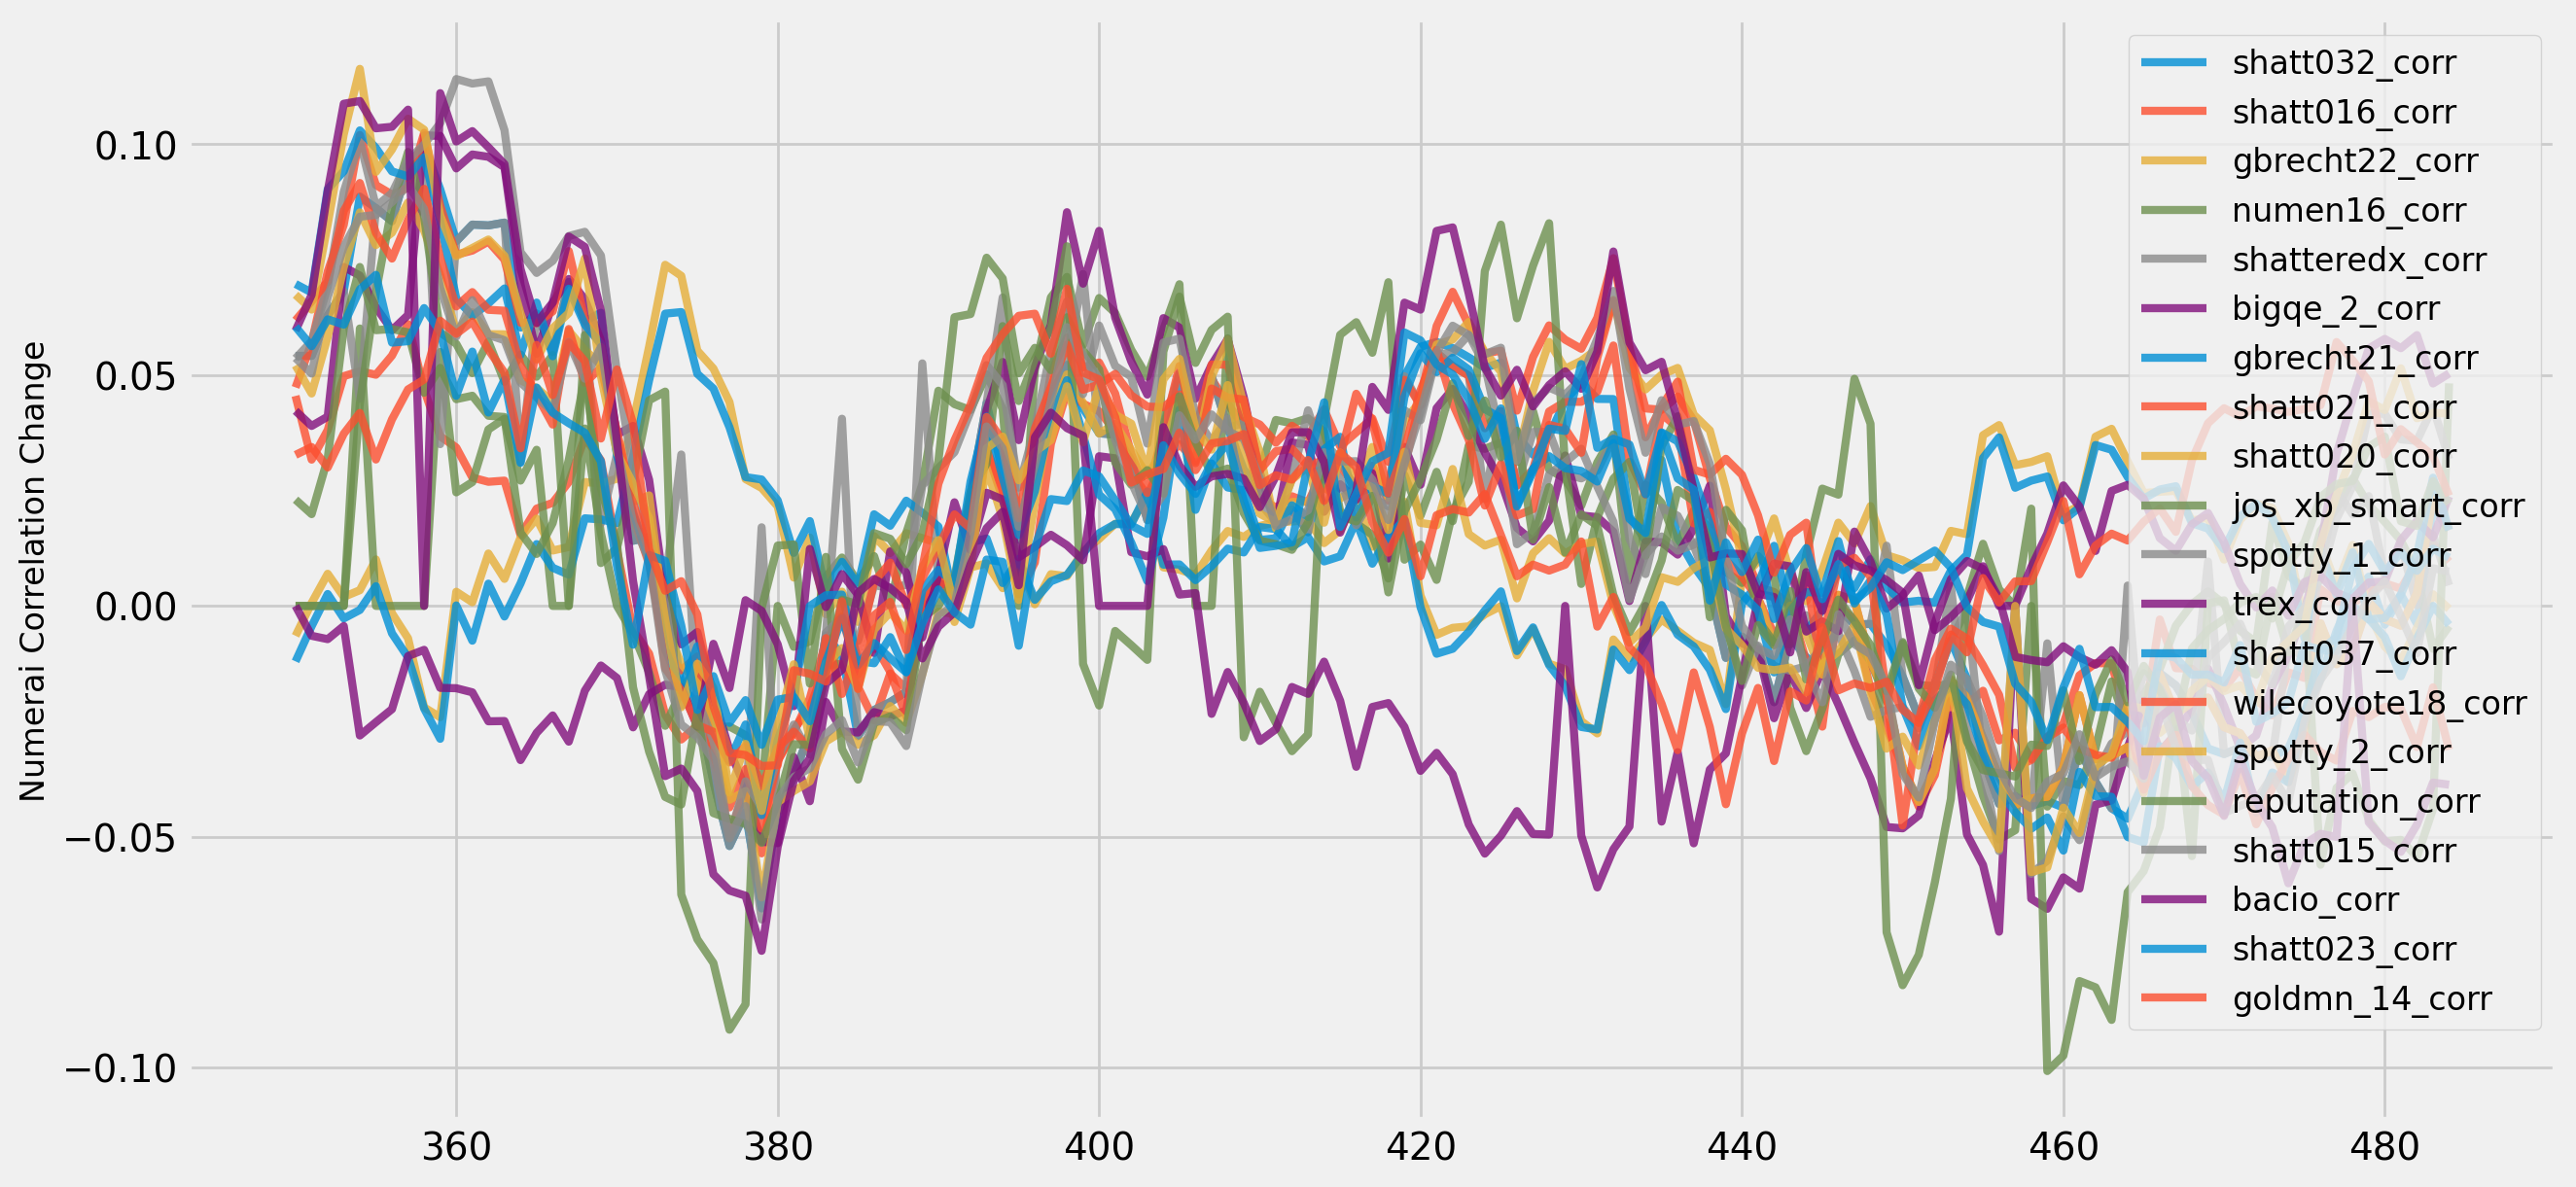

In [49]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

corr_cols=[col for col in metrics_summary_final.columns if col.endswith('_corr')]
corr_returns = metrics_summary_final[corr_cols]
plt.figure(figsize=(14, 7))
for c in corr_returns.columns.values:
    plt.plot(corr_returns.index, corr_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

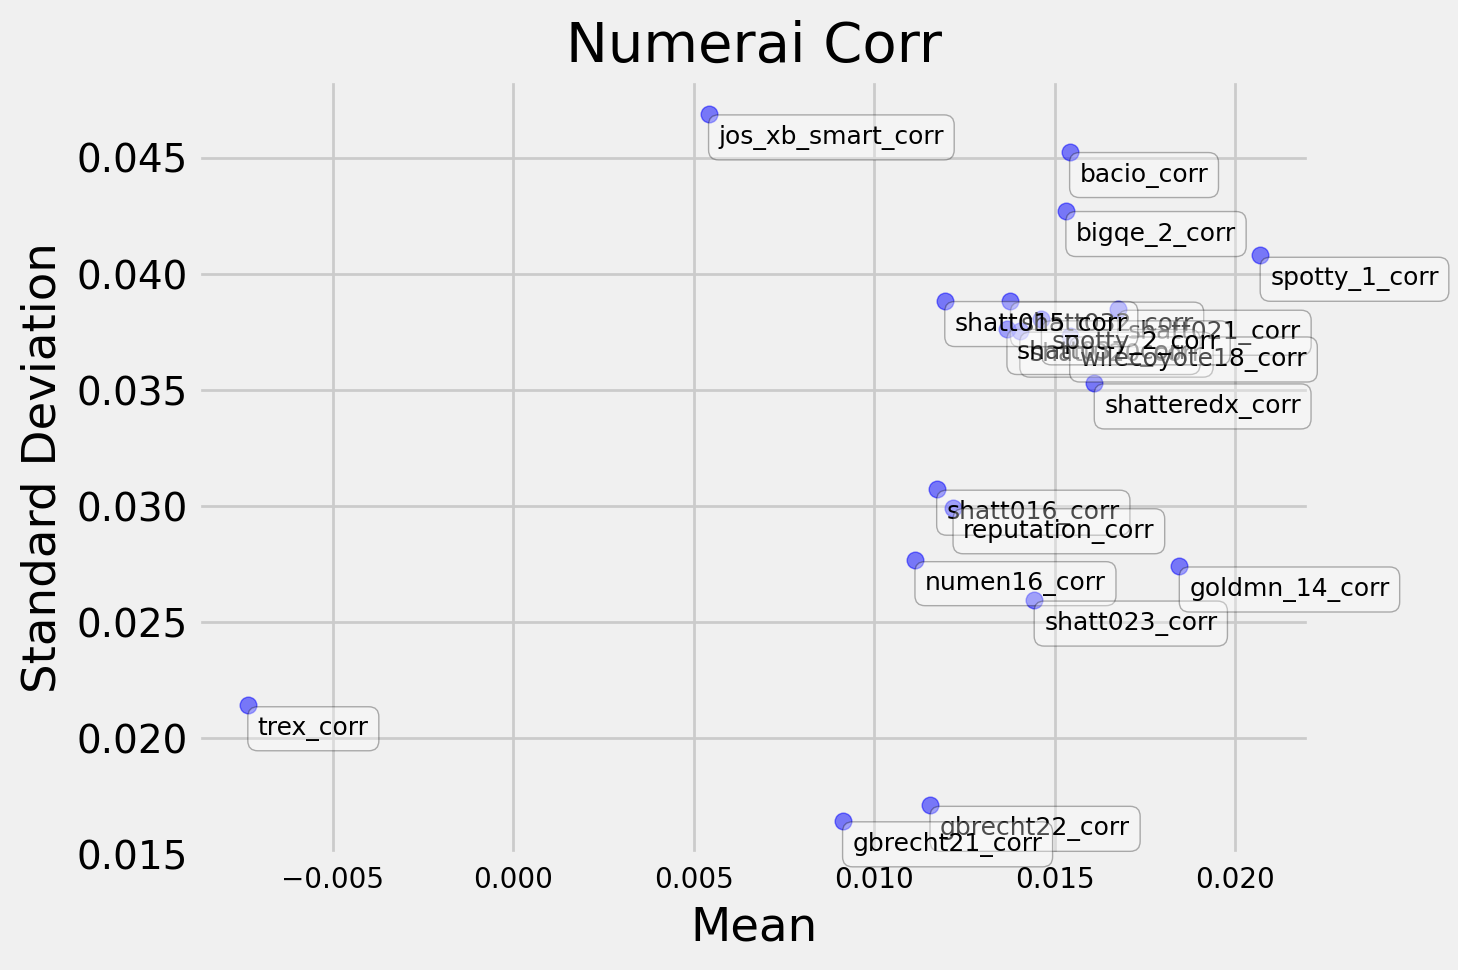

In [50]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='Numerai Corr'
all_mean=corr_returns.mean(axis=0)
all_std=corr_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.xticks(fontsize=10, rotation=0)
plt.title(f'{metric_name}')

# Display the plot
plt.show()

## True Contribution

Text(0, 0.5, 'Numerai Correlation Change')

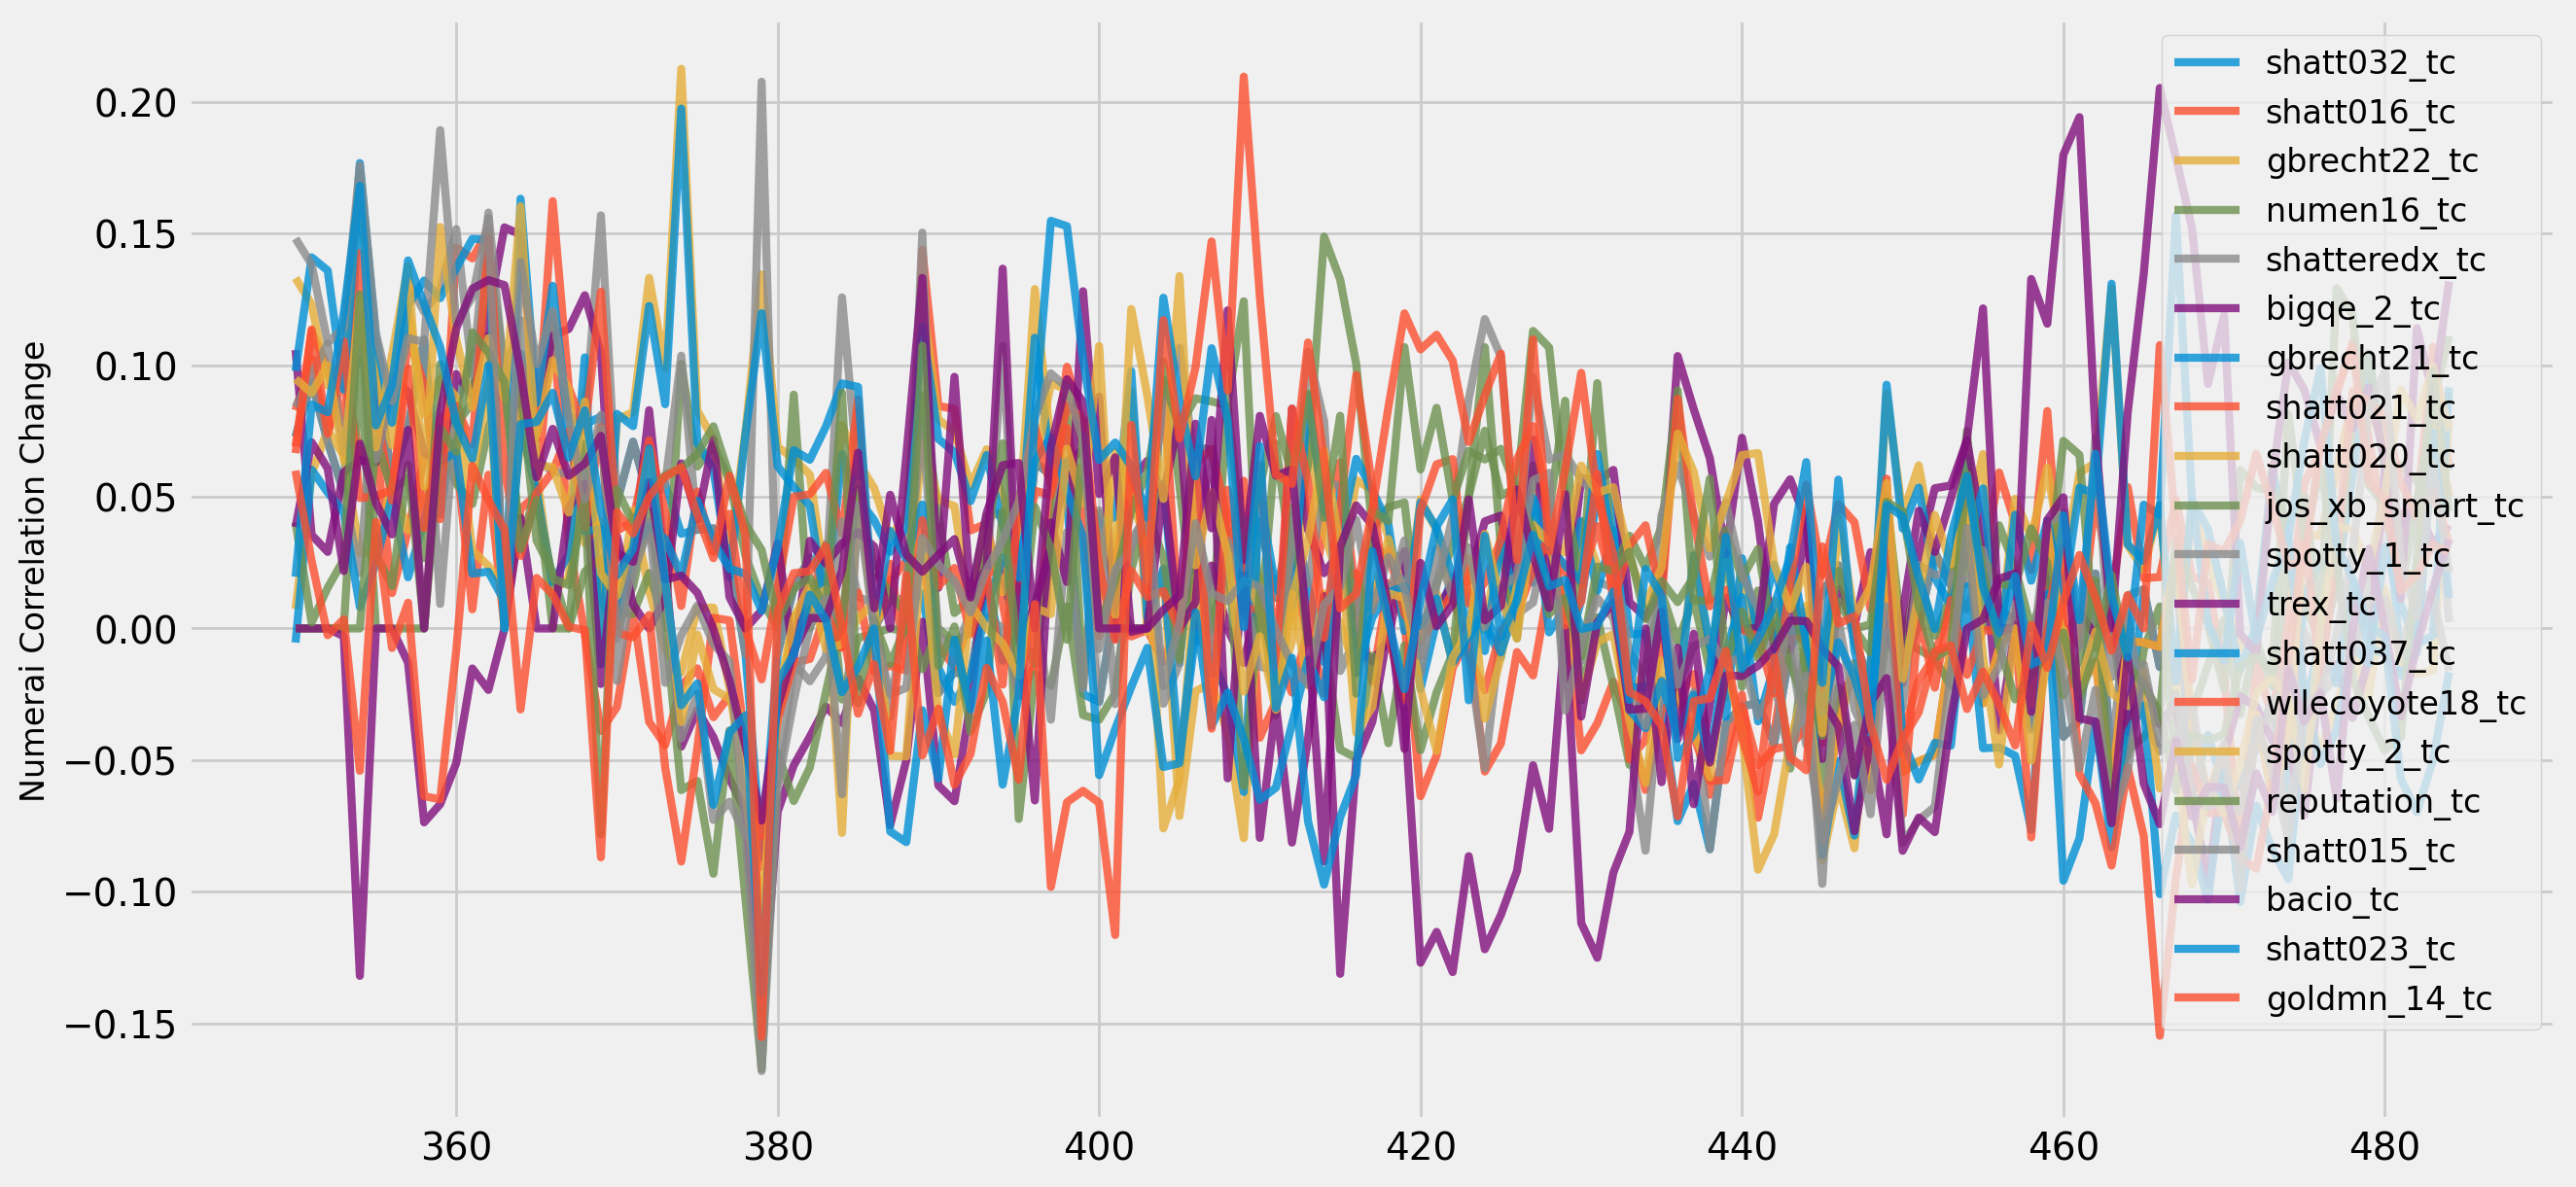

In [51]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tc_cols=[col for col in metrics_summary_final.columns if col.endswith('_tc')]
tc_returns = metrics_summary_final[tc_cols]
plt.figure(figsize=(14, 7))
for c in tc_returns.columns.values:
    plt.plot(tc_returns.index, tc_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

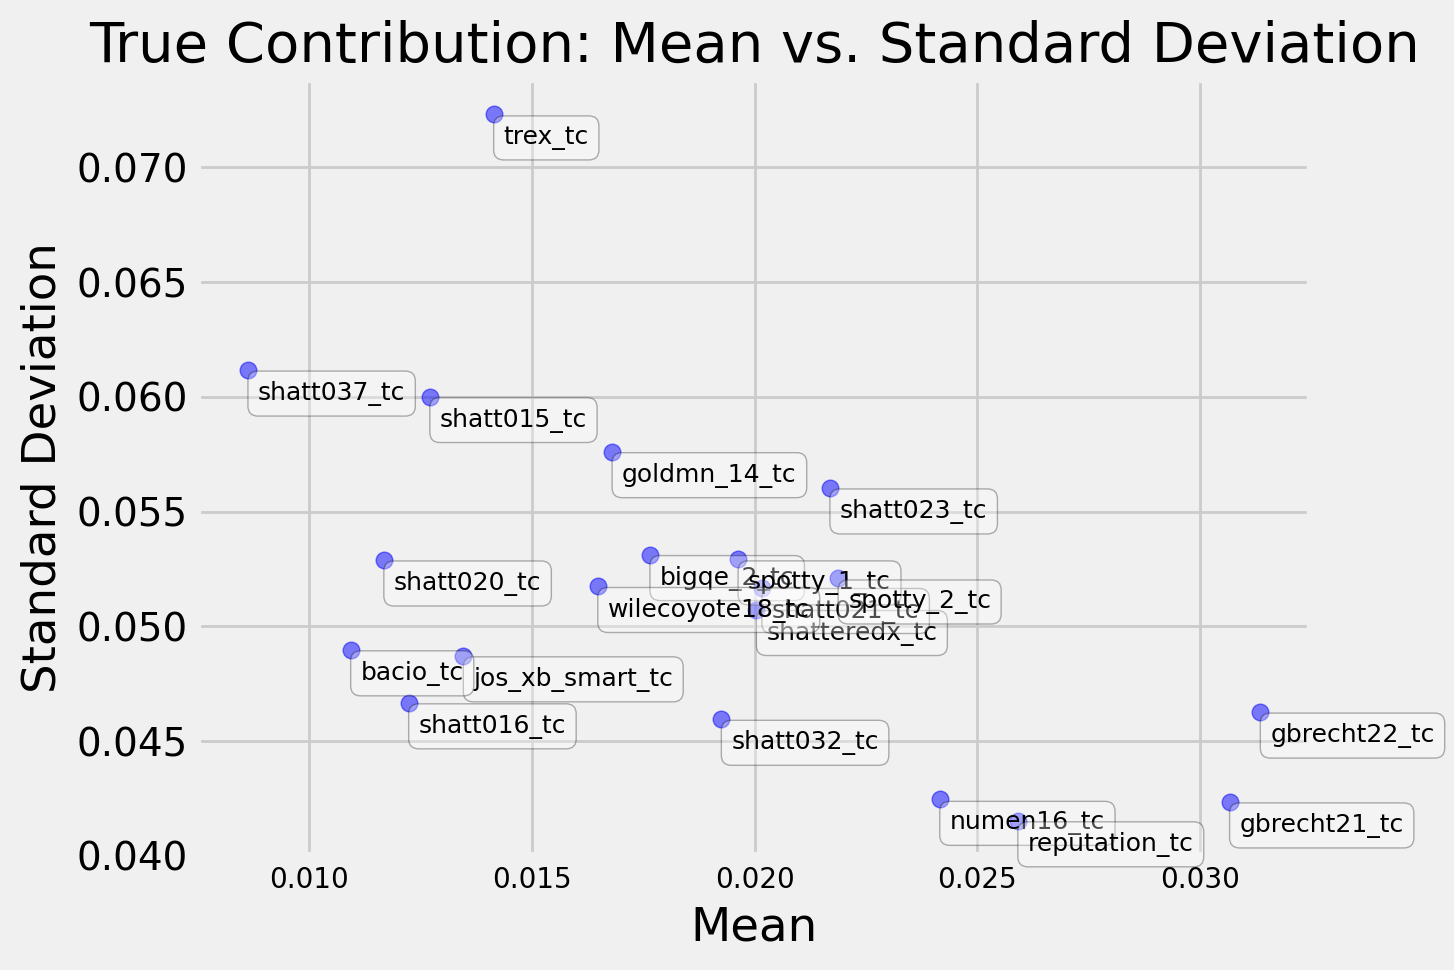

In [52]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='True Contribution'
all_mean=tc_returns.mean(axis=0)
all_std=tc_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.xticks(fontsize=10, rotation=0)
plt.title(f'{metric_name}: Mean vs. Standard Deviation')

# Display the plot
plt.show()

# Generate portfolio and plot Efficient Frontier

In [53]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    '''
    Calculates the annualized returns and volatility (standard deviation) of a portfolio, by each model's weights
    - Assumes portfolio will compound over the year, 52 weeks per year, 5 rounds per week
    '''
    returns = np.sum(mean_returns*weights) *52*5 #52 weeks per year, 5 rounds per week
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52*5)
    return std, returns

def calculate_return_mean_conv(raw_metrics_df, model_list, multipliers, payout_factor=0.1):
    '''
    Calculates the mean returns and covariance matrix of the models, based on each model's corr and tc multipliers
    - raw_metrics_df: the raw metrics dataframe
    - model_list: list of models to be included in the portfolio
    - multipliers: array of multipliers for each model's corr->multipliers[0] and tc->multipliers[1]
    - payout_factor: payout factor for the tournament, at current daily rounds, it's ~0.1
    '''
    
    corr_cols=[model+'_corr' for model in model_list]
    corr_return=(raw_metrics_df[corr_cols]*multipliers[0]).rename({col:col.replace('_corr','') for col in corr_cols},axis=1)
    
    tc_cols=[model+'_tc' for model in model_list]
    tc_return=(raw_metrics_df[tc_cols]*multipliers[1]).rename({col:col.replace('_tc','') for col in tc_cols},axis=1)
    
    total_return=np.add(corr_return,tc_return)*payout_factor
    mean_returns=total_return.mean()
    cov_matrix=total_return.cov()
    return mean_returns, cov_matrix
  
def random_portfolios(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=True):
    '''
    Generates N random portfolios with randomized weights for each model
    # model_list: list of models to be included in the portfolio
    # num_portfolios: number of simulated portfolios to be generated
    # risk_free_rate: risk free rate, for Sharpe ratio calculation, can set to 0 if not needed
    # rand_multiplier: whether to randomize the multipliers for each model's corr and tc
    '''
    results = np.zeros((3,num_portfolios))
    weights_record = []
    multiplier_record=[]
    
    corr_multipliers=[0.5,1] # skip 0 for now
    tc_multipliers=[0,0.5,1,2,3] # skip 1.5, 2.5 for now
    
    model_count=len(model_list)
    
    for i in range(num_portfolios):
        # Generate random weights by no. of models
        weights = np.random.random(model_count) # generate random weights by no. of models
        weights /= np.sum(weights)
        weights = np.round(weights/0.01)*0.01 # round to nearest integer
        weights_record.append(weights)
        
        # Calculate each portfolio's annualized return and volatility (standard dev.)
        if rand_multiplier:
            # Pick random multipliers for each of corr/TC
            multipliers=(np.random.choice(corr_multipliers,size=model_count),
                         np.random.choice(tc_multipliers,size=model_count))
            multiplier_record.append(multipliers)
            # Calculate the mean returns and covariance matrix based on the random multipliers
            
        else:
            # If do not randomize, default corr multiplier=>1, TC multiplier=>0
            multipliers=(np.ones(model_count),
                         np.zeros(model_count))
            multiplier_record.append(multipliers)
        # Calculate the mean returns and covariance matrix based on the given multipliers
        mean_returns, cov_matrix= calculate_return_mean_conv(raw_metrics_df,model_names,multipliers)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        
        # Store the portfolio's standard dev
        results[0,i] = portfolio_std_dev
        # Store portfolio's return
        results[1,i] = portfolio_return
        # Store portfolio's Sharp ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
        # Verbose
        #if i%10000==0:
        #    print(i)
    return results, weights_record, multiplier_record

In [54]:
#def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
def display_simulated_ef_with_random(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=True):
    '''
    Plot the Efficient Frontier with random portfolios, return array of results, weights and multipliers
    '''
    results, weights_record, multiplier_record = random_portfolios(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=rand_multiplier)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(zip(weights_record[max_sharpe_idx],multiplier_record[max_sharpe_idx][0],multiplier_record[max_sharpe_idx][1]),
                                         index=model_list, 
                                         columns=['allocation_percent','corr_multiplier','tc_multiplier'])    
    max_sharpe_allocation.allocation_percent = [round(i*100,2)for i in max_sharpe_allocation.allocation_percent]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(zip(weights_record[min_vol_idx],multiplier_record[min_vol_idx][0],multiplier_record[min_vol_idx][1]),
                                      index=model_list, 
                                      columns=['allocation_percent','corr_multiplier','tc_multiplier'])
    min_vol_allocation.allocation_percent = [round(i*100,2)for i in min_vol_allocation.allocation_percent]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    return results, weights_record, multiplier_record

In [55]:
#metrics_summary_final

In [56]:
# Currently only support _corr or _tc only
corr_cols = [col for col in metrics_summary_final.columns if col.endswith('_corr')]
tc_cols = [col for col in metrics_summary_final.columns if col.endswith('_tc')]
num_portfolios = 50000 # Suggested to be number_of_models *10000
risk_free_rate = 0.01 # For Sharpe ratio calculation
raw_metrics_df=metrics_summary_final


In [57]:
len(model_names)

20

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.95
Annualised Volatility: 0.06


                    shatt032  shatt016  gbrecht22  numen16  shatteredx  bigqe_2  gbrecht21  shatt021  shatt020  jos_xb_smart  spotty_1  trex  shatt037  wilecoyote18  spotty_2  reputation  shatt015  bacio  shatt023  goldmn_14
allocation_percent       2.0       1.0        6.0      9.0         3.0      1.0        8.0       4.0       0.0           7.0       4.0  10.0       3.0           1.0      10.0         6.0       8.0    6.0       7.0        6.0
corr_multiplier          1.0       1.0        1.0      1.0         1.0      1.0        1.0       0.5       0.5           0.5       1.0   0.5       0.5           0.5       1.0         0.5       1.0    1.0       1.0        1.0
tc_multiplier            0.5       1.0        3.0      1.0         2.0      0.5        3.0       0.0       1.0           0.5       0.0   2.0       

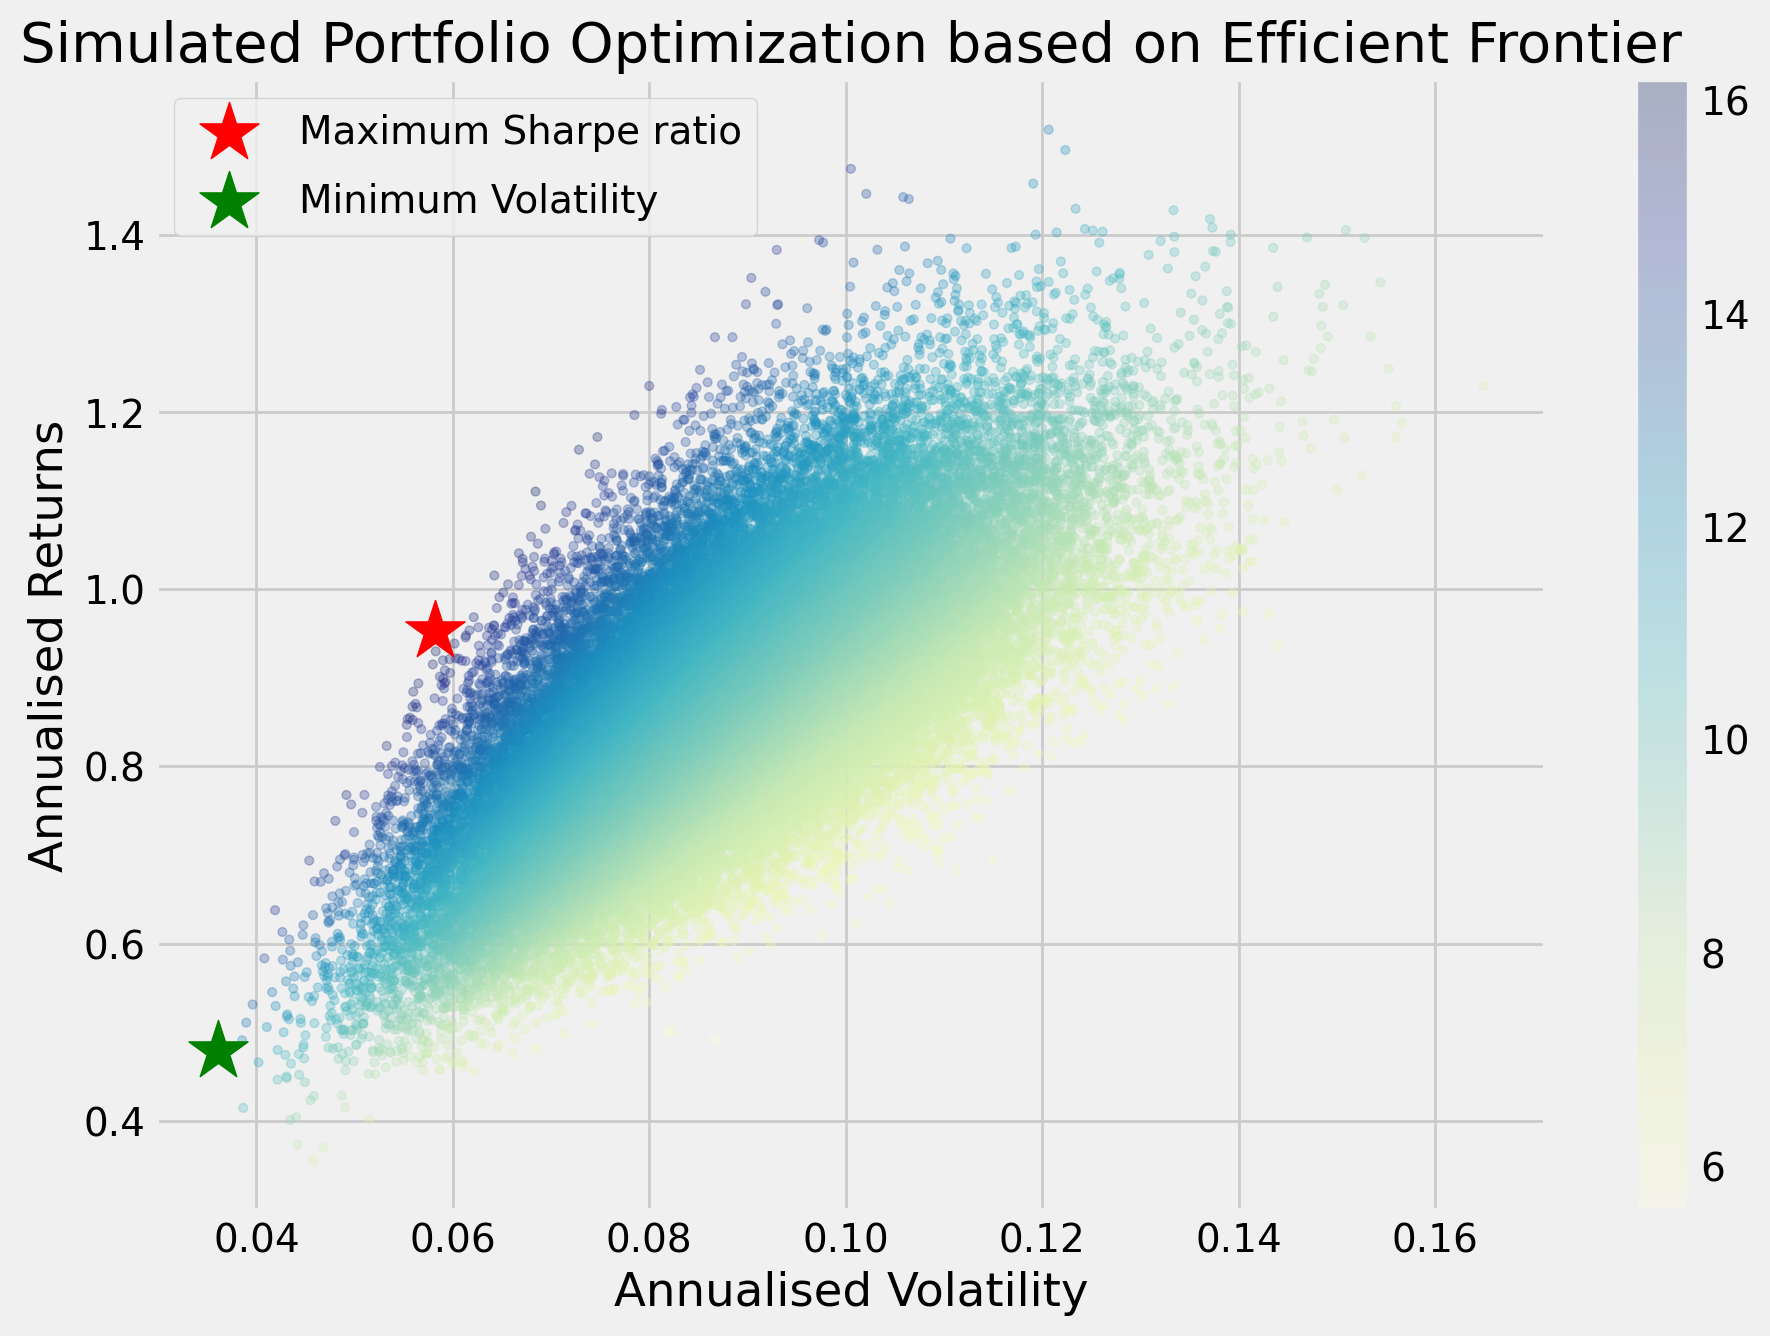

In [58]:
# Plot the efficient frontier for the simulated portfolios
results, weights_record, multiplier_record = display_simulated_ef_with_random(raw_metrics_df, model_names, num_portfolios, risk_free_rate, rand_multiplier=True)

Work-in-progress, create table to sort and select models by
- Max Sharpe Ratio
- Max Return
- Min Volatility

In [34]:
max_sharpe_idx_desc = sorted(range(len(results[2])), key=lambda i: results[2][i], reverse=True)
max_return_idx_desc = sorted(range(len(results[1])), key=lambda i: results[1][i], reverse=True)
min_vol_idx_desc = sorted(range(len(results[0])), key=lambda i: results[0][i], reverse=False)